In [1]:
import pandas as pd
import torch.nn as nn

from utils import *
from sklearn.metrics import ndcg_score
from models.NGCF.NGCF import NGCF
from models.MF.MF import MF

from matplotlib import pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
columnToken_common = ['性别', '省', '民族', '宗教信仰', '学历', '体型']
columnToken_nurse = ['常驻医院', '主要负责病区', '其他负责病区']
columnToken_patient = ['过敏史', '是否残疾', '暴露史', '是否吸烟', '是否饮酒', '常饮酒类', '所属医院', '所在病区']

columnNumber_common = ['年龄', '身高', '体重', 'BMI指数']
columnNumber_nurse = ['普通话程度', '方言程度', '在岗时间', '擅长科室种类', '接单数', '活跃度', '评分']
columnNumber_patient = ['烟龄', '平均每日吸烟次数', '平均每日饮酒次数', '锻炼频率', '刷牙频率', '重症等级']

nurseColumns = columnNumber_common + columnNumber_nurse + columnToken_common + columnToken_nurse
patientColumns = columnNumber_common + columnNumber_patient + columnToken_common + columnToken_patient

In [4]:
HAT_config_nurse = {
    'num_HAT_layers': 3,
    'in_features': [8, 16, 16],
    'out_features': [16, 16, 32],
    'num_softmax_layers': [5, 3, 1],
    'all_dims': [len(nurseColumns), 5, 3],
    'softmax_dims': [
        [[0, 1, 2, 3, 11, 12, 13, 14, 15, 16], [0, 3, 16], [4, 5], [6, 7, 8, 9, 10, 15], [17, 18, 19]],
        [[0], [1, 2, 3], [4]],
        [[0, 1, 2]]
    ]
}
HAT_config_patient = {
    'num_HAT_layers': 3,
    'in_features': [8, 16, 16],
    'out_features': [16, 16, 32],
    'num_softmax_layers': [5, 3, 1],
    'all_dims': [len(patientColumns), 5, 3],
    'softmax_dims': [
        [[0, 1, 2, 3, 10, 11, 12, 13, 14, 15], [0, 3, 9, 15, 17], [16, 18], [4, 5, 6, 7, 8, 19, 20, 21], [22, 23]],
        [[0], [1, 2, 3], [4]],
        [[0, 1, 2]]
    ]
}

GAT_config = {
    'num_of_layers': 2,
    'num_heads_per_layer': [8, 1],
    'num_features_per_layer': [96, 8, 8],
    'dropout_prob': 0.6,
    'bias': True,
    'add_skip_connection': False
}
GAT_config_nurse = {
    'num_of_layers': 2,
    'num_heads_per_layer': [8, 1],
    'num_features_per_layer': [len(nurseColumns) * 8, 8, 8],
    'dropout_prob': 0.6,
    'bias': True,
    'add_skip_connection': False
}
GAT_config_patient = {
    'num_of_layers': 2,
    'num_heads_per_layer': [8, 1],
    'num_features_per_layer': [len(patientColumns) * 8, 8, 8],
    'dropout_prob': 0.6,
    'bias': True,
    'add_skip_connection': False
}

GCN_config = {
    'input_features': 96,
    'hidden_features': 16,
    'out_features': 8,
    'dropout': 0.5
}
GCN_config_nurse = {
    'input_features': len(nurseColumns) * 8,
    'hidden_features': 16,
    'out_features': 8,
    'dropout': 0.5
}
GCN_config_patient = {
    'input_features': len(patientColumns) * 8,
    'hidden_features': 16,
    'out_features': 8,
    'dropout': 0.5
}

In [5]:
nurseData = pd.read_csv('data/nurseData_200.csv')
patientData = pd.read_csv('data/patientData_1000.csv')

nurseData_test = pd.read_csv('data/inductive/test/nurseData.csv')
patientData_test = pd.read_csv('data/inductive/test/patientData.csv')

tokenCount = getVocabulary('data/token2Id.txt')

# 标签数据
indexData_test, scoreData_test = getLabels('data/test/testLabels_200_1000_10.txt', device)

indexData_test_inductive, scoreData_test_inductive = getLabels('data/inductive/test/labels.txt', device)

nurseData_token = getData(nurseData, columnToken_common + columnToken_nurse, True, device)
nurseData_number = getData(nurseData, columnNumber_common + columnNumber_nurse, False, device)
patientData_token = getData(patientData, columnToken_common + columnToken_patient, True, device)
patientData_number = getData(patientData, columnNumber_common + columnNumber_patient, False, device)

nurseData_token_test = getData(nurseData_test, columnToken_common + columnToken_nurse, True, device)
nurseData_number_test = getData(nurseData_test, columnNumber_common + columnNumber_nurse, False, device)
patientData_token_test = getData(patientData_test, columnToken_common + columnToken_patient, True, device)
patientData_number_test = getData(patientData_test, columnNumber_common + columnNumber_patient, False, device)

# 获取边数据
edgeData_nurse_test = getEdges('data/inductive/test/edge_nurse_0.9_dist.txt', device)
edgeData_patient_test = getEdges('data/inductive/test/edge_patient_0.9_dist.txt', device)

# 使用曼哈顿距离+阈值取0.9
adjData_nurse = getAdj('data/edge/200_1000/edge_nurse_0.9_dist.txt', nurseData.shape[0], device)
adjData_patient = getAdj('data/edge/200_1000/edge_patient_0.9_dist.txt', patientData.shape[0], device)

# 使用余弦相似度+阈值取0.9
adjData_nurse_cosine = getAdj('data/edge/200_1000/edge_nurse_0.9.txt', nurseData.shape[0], device)
adjData_patient_cosine = getAdj('data/edge/200_1000/edge_patient_0.9.txt', patientData.shape[0], device)

# 引入传播系数矩阵
adjData_nurse_dist = getAdj('data/edge/200_1000/edge_nurse_0.9_dist.txt', nurseData.shape[0], device,
                            basedDist=True, filePath_dist='data/dist_matrix_nurse.txt')
adjData_patient_dist = getAdj('data/edge/200_1000/edge_patient_0.9_dist.txt', patientData.shape[0], device,
                              basedDist=True, filePath_dist='data/dist_matrix_patient.txt')

adjData = getAdj_NGCF('data/n2p.txt', device)

In [6]:
def evaluate(y_pred, y_true):
    # MAE
    criterion = nn.L1Loss()
    MAE_value = criterion(y_pred, y_true)

    # 决定系数
    y_mean = torch.mean(y_true)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    R2_value = 1 - (ss_res / ss_tot)

    return round(MAE_value.item(), 4), round(R2_value.item(), 4)

In [7]:
def getM(filePath, y_pred):
    m = {}
    with open(filePath, 'r') as file:
        for j, line in enumerate(file.readlines()):
            line = line.replace('\n', '')

            [nurse, _] = line.split(': ')[0].split('-')
            scores = float(line.split(': ')[1])

            if nurse not in m.keys():
                m[nurse] = [[scores], [y_pred[j].item()]]
            else:
                m[nurse][0].append(scores)
                m[nurse][1].append(y_pred[j].item())

    return m

In [8]:
def getHR(m, k):
    HRs_k = []
    for key in m.keys():
        y_true, y_pred = m[key][0], m[key][1]

        k = min(k, len(y_true))
        topK_true = [i for i, _ in sorted(enumerate(y_true), key=lambda x: x[1], reverse=True)[:k]]
        topK_pred = [i for i, _ in sorted(enumerate(y_pred), key=lambda x: x[1], reverse=True)[:k]]

        hit_count = 0
        for item in topK_pred:
            if item in topK_true:
                hit_count += 1
        hit_ratio = hit_count / k

        HRs_k.append(hit_ratio)

    return round(sum(HRs_k) / len(HRs_k), 4)

In [1626]:
model = MF(n_users=200, n_items=1000, embedding_dim=8, mlp_config={
    'input_features': 8 + 8,
    'hidden_features': 32
}).to(device)
model.load_state_dict(torch.load('history/bestModel_MF_2024-11-14_20-45-40_0.1200.pth'))

preds = model(indexData_test).squeeze()
MAE, R2 = evaluate(preds, scoreData_test)

m = getM('data/test/testLabels_200_1000_10.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'MF\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

MF	MAE=0.12	R2=0.3353	nDCG=0.7247
HR@1=0.04
HR@5=0.225
HR@10=0.361
HR@50=0.8946


In [1627]:
model = NGCF(n_users=200, n_items=1000, embedding_dim=8, weight_size=[64], dropout_list=[0.1], mlp_config={
    'input_features': 72 + 72,
    'hidden_features': 32
}).to(device)
model.load_state_dict(torch.load('history/bestModel_NGCF_2024-11-14_20-09-30_0.1147.pth'))

preds = model(adjData, indexData_test).squeeze()
MAE, R2 = evaluate(preds, scoreData_test)


m = getM('data/test/testLabels_200_1000_10.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'NGCF\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

NGCF	MAE=0.1148	R2=0.3397	nDCG=0.7654
HR@1=0.075
HR@5=0.278
HR@10=0.4395
HR@50=0.889


In [21]:
onlyGCN = getModelConfig(n_count_nurse=nurseData_number.shape[1], n_count_patient=patientData_number.shape[1],
                         t_count=tokenCount, embedded_size=8,
                         useHAT=False, hat_config_nurse=None, hat_config_patient=None,
                         useGAT=False, gat_config_nurse=None, gat_config_patient=None,
                         useGCN=True, gcn_config_nurse=GCN_config_nurse, gcn_config_patient=GCN_config_patient)
setSeed(1950)
model = getModel(onlyGCN[0], onlyGCN[1], isOnlyHAT=False).to(device)
model.load_state_dict(torch.load('history/bestModel_GCN(dist)_2024-11-13_21-46-59_0.0993.pth'))

preds = model((nurseData_number, nurseData_token, adjData_nurse_dist),
              (patientData_number, patientData_token, adjData_patient_dist), indexData_test).squeeze()
MAE, R2 = evaluate(preds, scoreData_test)


m = getM('data/test/testLabels_200_1000_10.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'GCL\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

GCL	MAE=0.0994	R2=0.6183	nDCG=0.889
HR@1=0.145
HR@5=0.492
HR@10=0.674
HR@50=0.8921


In [1629]:
onlyGCN = getModelConfig(n_count_nurse=nurseData_number.shape[1], n_count_patient=patientData_number.shape[1],
                         t_count=tokenCount, embedded_size=8,
                         useHAT=False, hat_config_nurse=None, hat_config_patient=None,
                         useGAT=False, gat_config_nurse=None, gat_config_patient=None,
                         useGCN=True, gcn_config_nurse=GCN_config_nurse, gcn_config_patient=GCN_config_patient)
setSeed(2083)
model = getModel(onlyGCN[0], onlyGCN[1], isOnlyHAT=False).to(device)
model.load_state_dict(torch.load('history/2024-11-13_17-55-28/bestModel_GCN_2024-11-13_17-55-28_0.1073.pth'))

preds = model((nurseData_number, nurseData_token, adjData_nurse),
              (patientData_number, patientData_token, adjData_patient), indexData_test).squeeze()
MAE, R2 = evaluate(preds, scoreData_test)


m = getM('data/test/testLabels_200_1000_10.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'GCN\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

GCN	MAE=0.1091	R2=0.5685	nDCG=0.8788
HR@1=0.115
HR@5=0.459
HR@10=0.6555
HR@50=0.8754


In [1630]:
onlyGAT = getModelConfig(n_count_nurse=nurseData_number_test.shape[1],
                         n_count_patient=patientData_number_test.shape[1],
                         t_count=tokenCount, embedded_size=8,
                         useHAT=False, hat_config_nurse=None, hat_config_patient=None,
                         useGAT=True, gat_config_nurse=GAT_config_nurse, gat_config_patient=GAT_config_patient,
                         useGCN=False, gcn_config_nurse=None, gcn_config_patient=None)
setSeed(2082)
model = getModel(onlyGAT[0], onlyGAT[1], isOnlyHAT=False).to(device)
model.load_state_dict(torch.load('history/2024-11-12_20-40-15/bestModel_GAT_2024-11-12_20-40-15_0.1778.pth'))

preds = model((nurseData_number_test, nurseData_token_test, edgeData_nurse_test),
              (patientData_number_test, patientData_token_test, edgeData_patient_test), indexData_test_inductive).squeeze()
MAE, R2 = evaluate(preds, scoreData_test_inductive)

m = getM('data/inductive/test/labels.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'GAT\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

GAT	MAE=0.1743	R2=0.0091	nDCG=0.5745
HR@1=0.0
HR@5=0.11
HR@10=0.17
HR@50=0.585


In [1631]:
onlyGCN = getModelConfig(n_count_nurse=nurseData_number.shape[1], n_count_patient=patientData_number.shape[1],
                         t_count=tokenCount, embedded_size=8,
                         useHAT=False, hat_config_nurse=None, hat_config_patient=None,
                         useGAT=False, gat_config_nurse=None, gat_config_patient=None,
                         useGCN=True, gcn_config_nurse=GCN_config_nurse, gcn_config_patient=GCN_config_patient)
setSeed(2024)
model = getModel(onlyGCN[0], onlyGCN[1], isOnlyHAT=False).to(device)
model.load_state_dict(torch.load('history/2024-11-12_20-40-15/bestModel_GCN_2024-11-12_20-40-15_0.1346.pth'))

preds = model((nurseData_number, nurseData_token, adjData_nurse_cosine),
              (patientData_number, patientData_token, adjData_patient_cosine), indexData_test).squeeze()
MAE, R2 = evaluate(preds, scoreData_test)


m = getM('data/test/testLabels_200_1000_10.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'GCN(cosine)\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

GCN(cosine)	MAE=0.1226	R2=0.4553	nDCG=0.8347
HR@1=0.105
HR@5=0.363
HR@10=0.5965
HR@50=0.8649


In [15]:
onlyHAT = getModelConfig(n_count_nurse=nurseData_number.shape[1], n_count_patient=patientData_number.shape[1],
                         t_count=tokenCount, embedded_size=8,
                         useHAT=True, hat_config_nurse=HAT_config_nurse, hat_config_patient=HAT_config_patient,
                         useGAT=False, gat_config_nurse=None, gat_config_patient=None,
                         useGCN=False, gcn_config_nurse=None, gcn_config_patient=None)
setSeed(2024)
model = getModel(onlyHAT[0], onlyHAT[1], isOnlyHAT=True).to(device)
model.load_state_dict(torch.load('history/2024-11-13_17-55-28/bestModel_HAT_2024-11-13_17-55-28_0.0603.pth'))

preds = model((nurseData_number, nurseData_token), (patientData_number, patientData_token), indexData_test).squeeze()
MAE, R2 = evaluate(preds, scoreData_test)

m = getM('data/test/testLabels_200_1000_10.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'HAGC-Rec(dist)\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

HAGC-Rec(dist)	MAE=0.0603	R2=0.866	nDCG=0.9699
HR@1=0.345
HR@5=0.7
HR@10=0.8105
HR@50=0.928


In [18]:
onlyHAT = getModelConfig(n_count_nurse=nurseData_number.shape[1], n_count_patient=patientData_number.shape[1],
                         t_count=tokenCount, embedded_size=8,
                         useHAT=True, hat_config_nurse=HAT_config_nurse, hat_config_patient=HAT_config_patient,
                         useGAT=False, gat_config_nurse=None, gat_config_patient=None,
                         useGCN=False, gcn_config_nurse=None, gcn_config_patient=None)
setSeed(2024)
model = getModel(onlyHAT[0], onlyHAT[1], isOnlyHAT=True).to(device)
model.load_state_dict(torch.load('history/2024-11-11_23-29-37/bestModel_HGA-Rec_2024-11-11_23-29-37_0.0736.pth'))

preds = model((nurseData_number, nurseData_token), (patientData_number, patientData_token), indexData_test).squeeze()
MAE, R2 = evaluate(preds, scoreData_test)

m = getM('data/test/testLabels_200_1000_10.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'HAGC-Rec\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

HAGC-Rec	MAE=0.0736	R2=0.8068	nDCG=0.9578
HR@1=0.255
HR@5=0.662
HR@10=0.79
HR@50=0.9146


In [1636]:
# HGCRec = getModelConfig(n_count_nurse=nurseData_number.shape[1], n_count_patient=patientData_number.shape[1],
#                         t_count=tokenCount, embedded_size=8,
#                         useHAT=True, hat_config_nurse=HAT_config_nurse, hat_config_patient=HAT_config_patient,
#                         useGAT=False, gat_config_nurse=None, gat_config_patient=None,
#                         useGCN=True, gcn_config_nurse=GCN_config, gcn_config_patient=GCN_config)
# setSeed(226)
# model = getModel(HGCRec[0], HGCRec[1], isOnlyHAT=False).to(device)
# model.load_state_dict(torch.load('history/2024-11-13_17-55-28/bestModel_HGC-Rec_2024-11-13_17-55-28_0.1153.pth'))
#
# preds = model((nurseData_number, nurseData_token, adjData_nurse_dist),
#               (patientData_number, patientData_token, adjData_patient_dist), indexData_test).squeeze()
# MAE, R2 = evaluate(preds, scoreData_test)
#
#
# m = getM('data/test/testLabels_200_1000_10.txt', preds)
# nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
# nDCG = round(sum(nDCGs) / len(nDCGs), 4)
#
# print(f'HAL\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')
#
# kList = [1, 5, 10, 50]
# for k in kList:
#     print(f'HR@{k}={getHR(m, k)}')

onlyGCN = getModelConfig(n_count_nurse=nurseData_number.shape[1], n_count_patient=patientData_number.shape[1],
                         t_count=tokenCount, embedded_size=8,
                         useHAT=False, hat_config_nurse=None, hat_config_patient=None,
                         useGAT=False, gat_config_nurse=None, gat_config_patient=None,
                         useGCN=True, gcn_config_nurse=GCN_config_nurse, gcn_config_patient=GCN_config_patient)
setSeed(2024)
model = getModel(onlyGCN[0], onlyGCN[1], isOnlyHAT=False).to(device)
model.load_state_dict(torch.load('history/bestModel_GCN_2024-11-13_21-50-15_0.1040.pth'))

preds = model((nurseData_number, nurseData_token, adjData_nurse),
              (patientData_number, patientData_token, adjData_patient), indexData_test).squeeze()
MAE, R2 = evaluate(preds, scoreData_test)


m = getM('data/test/testLabels_200_1000_10.txt', preds)
nDCGs = [ndcg_score([m[k][0]], [m[k][1]], k=10) for k in m.keys()]
nDCG = round(sum(nDCGs) / len(nDCGs), 4)

print(f'HAL\tMAE={MAE}\tR2={R2}\tnDCG={nDCG}')

kList = [1, 5, 10, 50]
for k in kList:
    print(f'HR@{k}={getHR(m, k)}')

HAL	MAE=0.1022	R2=0.6104	nDCG=0.8852
HR@1=0.15
HR@5=0.486
HR@10=0.673
HR@50=0.8892


In [2]:
import numpy as np

attention_20_0 = np.load('20_0_nurse.npy')
attention_max_list, attention_min_list = [], []
for i in range(attention_20_0.shape[0]):
    attention_max_list.append(np.max(attention_20_0[i]))
    attention_min_list.append(np.min(attention_20_0[i]))

for i in range(attention_20_0.shape[0]):
    for j in range(attention_20_0.shape[1]):
        attention_20_0[i][j] = (attention_20_0[i][j] - attention_min_list[i]) / (attention_max_list[i] - attention_min_list[i])

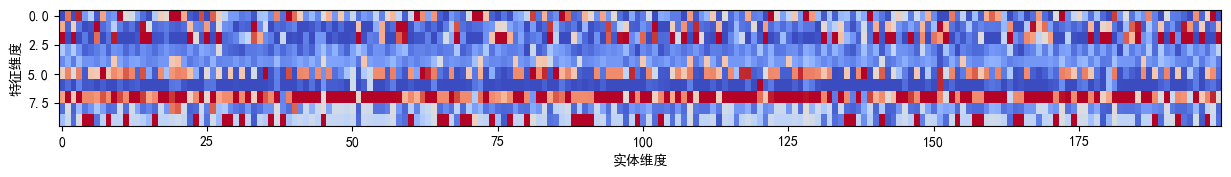

In [15]:
plt.figure(figsize=(15, 8))
plt.imshow(attention_20_0[list(range(200)), :].T, cmap=plt.cm.coolwarm, interpolation='nearest', aspect=2)
# plt.imshow(attention_20_0, cmap=plt.cm.coolwarm, interpolation='nearest')
plt.xlabel('实体维度')
plt.ylabel('特征维度')
# plt.title('Attention Heatmap')
# plt.colorbar()
plt.savefig('注意力热力图.png')
plt.show()

In [65]:
attention_24_0 = np.load('24_0_patient.npy')
attention_max_list, attention_min_list = [], []
for i in range(attention_24_0.shape[0]):
    attention_max_list.append(np.max(attention_24_0[i]))
    attention_min_list.append(np.min(attention_24_0[i]))

for i in range(attention_24_0.shape[0]):
    for j in range(attention_24_0.shape[1]):
        attention_24_0[i][j] = (attention_24_0[i][j] - attention_min_list[i]) / (attention_max_list[i] - attention_min_list[i])

array([[0.11234961, 0.9984667 , 0.10732868, ..., 0.        , 0.18172006,
        0.16383292],
       [0.14442581, 0.        , 0.04505529, ..., 0.01931962, 0.12254231,
        0.15867007],
       [0.0581497 , 0.06474119, 1.        , ..., 0.0238904 , 0.02969405,
        0.05967012],
       ...,
       [0.6989359 , 0.48369065, 1.        , ..., 0.04018361, 0.04994524,
        0.10036416],
       [0.09136105, 1.        , 0.58074427, ..., 0.0277687 , 0.03451426,
        0.06935637],
       [1.        , 0.        , 0.11184496, ..., 0.06569493, 0.12107868,
        0.14046253]], dtype=float32)

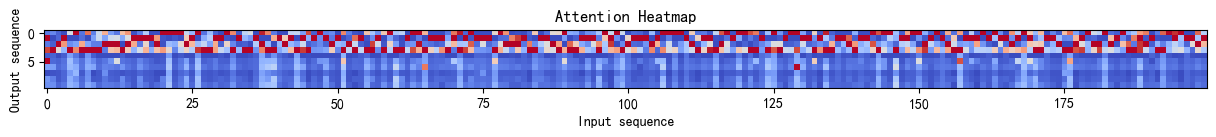

In [86]:
plt.figure(figsize=(15, 6))
plt.imshow(attention_24_0[list(range(200)), :].T, cmap=plt.cm.coolwarm, interpolation='nearest')
plt.xlabel('Input sequence')
plt.ylabel('Output sequence')
plt.title('Attention Heatmap')
# plt.colorbar()
plt.show()